In [86]:
import pandas as pd
import numpy as np

In [16]:
data = pd.read_excel("FOMC_token_separated.xlsx")
data = data.dropna()

# Use meeting-aggregation to perform LDA with TF-IDF cleanup

In [39]:
meeting_text = []
for meeting in data['Date'].unique():
    meeting_text.append(' '.join(data.groupby('Date').get_group(meeting)['content'].values).split(' '))

In [20]:
import gensim
from gensim import corpora, models

C:\Users\barry\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [42]:
dictionary = corpora.Dictionary(meeting_text)

In [52]:
corpus = [dictionary.doc2bow(text) for text in meeting_text]

In [53]:
tfidf = models.TfidfModel(corpus, id2word = dictionary)

Follow HMP, we define the TF-IDF score for each term $t$ as 

$$
\text{TF-IDF}_t = Tf_t \times Df_t
$$
where $$Tf_t = 1+\log{n_t} = 1 + \log{\sum_d n_{t,d}}$$, and $$IDF_t = \log(\frac{D}{D_t}) = \log(\frac{D}{\sum_d \mathbb{1}\{n_{t,d} >0\}})$$

where $n_{t,d}$ is the count of term $t$ in document $d$. Note that this calculation is applied for the entire document, meaning that each term gets one TF-IDF score, as oppose to common practice where TF-IDF is calculated differently for the same term in different document

In [62]:
#In gensim default practice, the tf-idf of the same term (0) in different documents are different
print(tfidf[corpus][0][0])
print(tfidf[corpus][1][0])

(0, 0.021594972031988697)
(2, 0.000953251169690239)


In [95]:
# calculate our own tfidf
# first, we can extract term-document matrix as 
term_document = gensim.matutils.corpus2dense(corpus, num_terms=len(dictionary.keys()))

(11498, 148)

In [132]:
# Calculate tf-idf
TF = 1+np.log(term_document.sum(axis = 1))
IDF = np.log(term_document.shape[1] / np.count_nonzero(term_document, axis = 1))

TF_IDF = pd.Series(dict(zip(dictionary.keys(), TF*IDF)))
TF_IDF

0        4.118433
1        0.952854
2        0.103438
3        1.225809
4        3.107286
5        5.193166
6        1.412798
7        9.029460
8        0.174359
9        0.311120
10       4.997212
11       4.812495
12       3.823686
13       0.167170
14       1.391438
15       0.700080
16       9.773803
17       8.853012
18       0.305847
19       1.173733
20       0.172576
21       0.062154
22       0.000000
23       0.306943
24       0.323903
25       0.168990
26       8.646760
27       0.000000
28       4.748622
29       1.370186
           ...   
11468    4.997212
11469    4.997212
11470    4.997212
11471    4.997212
11472    4.997212
11473    4.997212
11474    4.997212
11475    8.461016
11476    4.997212
11477    4.997212
11478    4.997212
11479    4.997212
11480    4.997212
11481    4.997212
11482    4.997212
11483    8.461016
11484    4.997212
11485    8.461016
11486    4.997212
11487    4.997212
11488    4.997212
11489    4.997212
11490    4.997212
11491    4.997212
11492    4

We keep the top 9000 terms with highest TF-IDF score

In [140]:
keys_to_use = TF_IDF.sort_values(ascending = False)[:9000].index.values

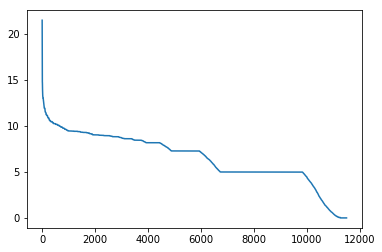

In [148]:
#We can plot the TF-IDF vs. the rank for each term
import matplotlib.pyplot as plt
TF_IDF.sort_values(ascending = False).reset_index()[0].plot()
plt.show()

Now we generate the term-document matrix for only the top 9000 terms, and implement Online Learning LDA

In [153]:
dictionary.filter_tokens(good_ids = keys_to_use)
new_corpus = [dictionary.doc2bow(text) for text in meeting_text]

In [155]:
ldamodel = models.ldamodel.LdaModel(new_corpus, num_topics=20, id2word = dictionary)

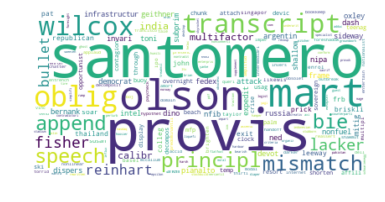

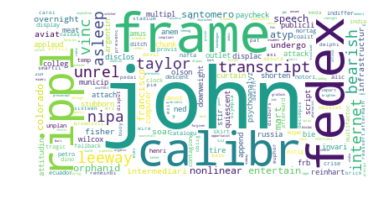

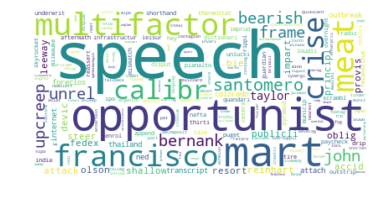

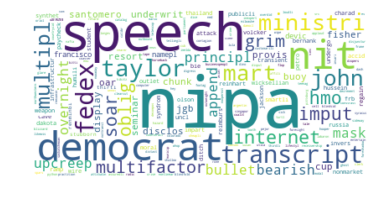

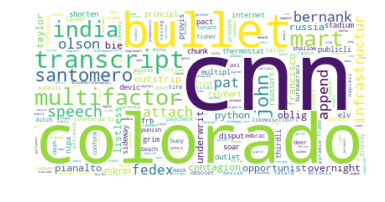

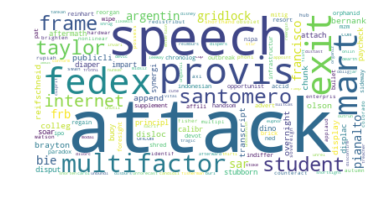

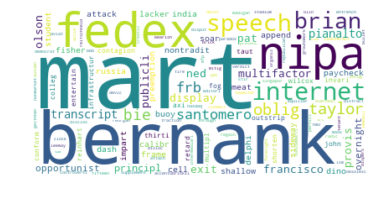

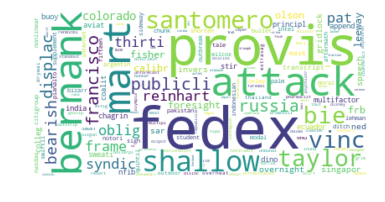

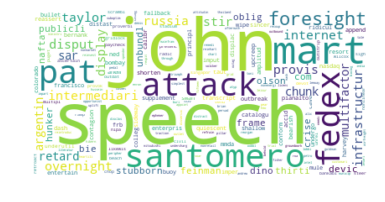

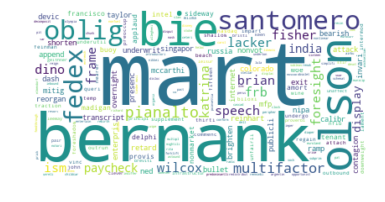

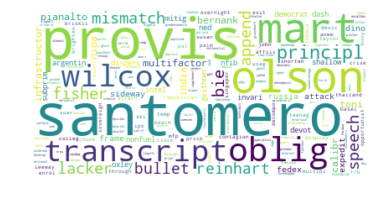

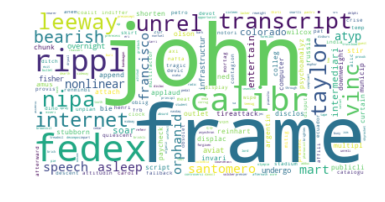

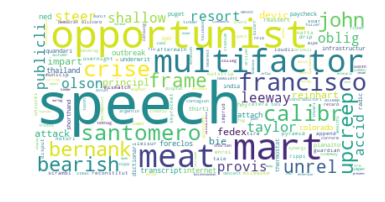

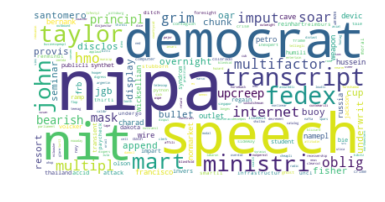

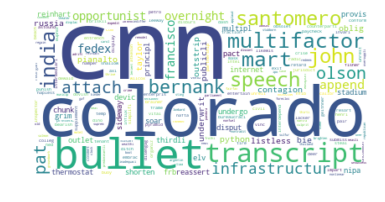

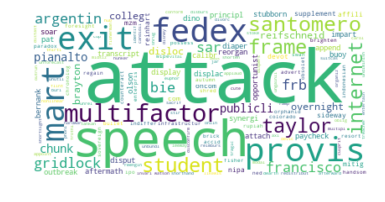

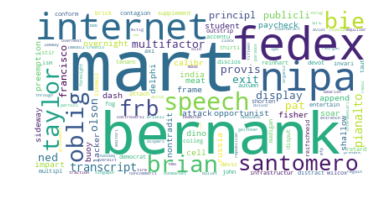

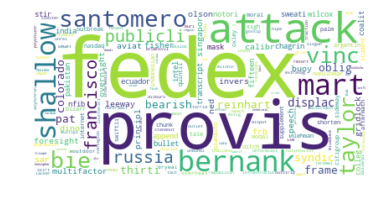

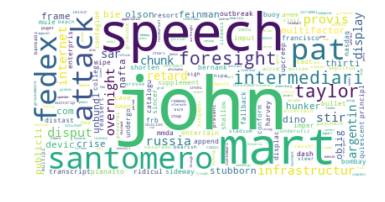

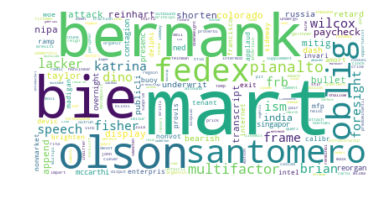

In [157]:
from wordcloud import WordCloud

for t in range(10):

    plt.figure()
    
    plt.imshow(WordCloud(background_color='white').fit_words(dict(ldamodel.show_topic(t,200))),interpolation='bilinear')
    
    plt.axis('off')
    
    plt.show()

# Using individual interjection to perform LDA with tf-idf cleanup

In [162]:
texts = []
for line in data['content'].values:
    texts.append(line.split(' '))

In [181]:
dictionary2.token2id

In [164]:
dictionary2 = corpora.Dictionary(texts)
corpus2 = [dictionary.doc2bow(text) for text in texts]
len(corpus2)

26092

In [179]:
term_document2 = gensim.matutils.corpus2dense(corpus2, num_terms=len(dictionary.keys()))

In [174]:
# Calculate tf-idf
TF2 = 1+np.log(term_document2.sum(axis = 1))
IDF2 = np.log(term_document2.shape[1] / np.count_nonzero(term_document2, axis = 1))

TF_IDF2 = pd.Series(dict(zip(dictionary2.keys(), TF2*IDF2)))
TF_IDF2

0       16.044664
1       31.664389
2       30.635253
3       31.201325
4       32.006926
5       24.225614
6       33.141857
7       16.044664
8       27.109424
9       27.905067
10      28.353494
11      27.403291
12      30.844966
13      16.044664
14      32.402222
15      25.798405
16      31.222026
17      30.537453
18      22.336648
19      29.210154
20      34.974425
21      25.488784
22      10.169384
23      25.865363
24      29.428930
25      30.285763
26      31.071848
27      31.495941
28      24.912505
29      32.392300
          ...    
3062    10.169384
3063    10.169384
3064    10.169384
3065    10.169384
3066    10.169384
3067    17.218264
3068    10.169384
3069    10.169384
3070    10.169384
3071    10.169384
3072    10.169384
3073    10.169384
3074    10.169384
3075    10.169384
3076    10.169384
3077    10.169384
3078    17.218264
3079    10.169384
3080    10.169384
3081    10.169384
3082    10.169384
3083    17.218264
3084    10.169384
3085    10.169384
3086    10

In [176]:
#keep the top 9000 terms
keys_to_use2 = TF_IDF2.sort_values(ascending = False)[:9000].index.values

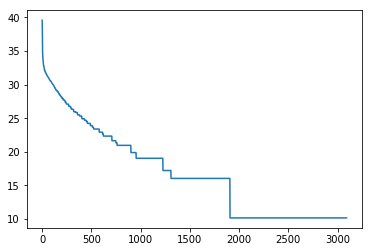

In [177]:
#We can plot the TF-IDF vs. the rank for each term
import matplotlib.pyplot as plt
TF_IDF2.sort_values(ascending = False).reset_index()[0].plot()
plt.show()